L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `GaussianLinearCalibration`.

On considère ici un modèle *exactement* linéaire. Pour cela, on simule la loi conditionnelle à posteriori de theta sachant les observations par une méthode d'échantillonage Monte-Carlo simple. On génère un échantillon grace à la loi à priori de theta. Puis on conditionne en sélectionnant les valeurs de theta réalisant un faible résidu. L'échantillon obtenu est issu de la loi à posteriori de theta sachant les observations.

## Generate the observations

In [1]:
import numpy as np
import openturns as ot

In [2]:
ot.RandomGenerator.SetSeed(0)

In [3]:
def modelLineaire(X):
    x,theta1,theta2,theta3 = X
    y = theta1 + theta2*x + theta3*x**2
    return [y]

In [4]:
g = ot.PythonFunction(4, 1, modelLineaire) 

In [5]:
descr = ["Theta1", "Theta2", "Theta3"]

In [6]:
trueParameter = ot.Point([11.11,6.6,-9.9])
trueParameter

class=Point name=Unnamed dimension=3 values=[11.11,6.6,-9.9]

In [7]:
parameterDimension = trueParameter.getDimension()
parameterDimension

3

Create the joint input distribution function.

In [8]:
X = ot.Uniform()
Theta1 = ot.Dirac(trueParameter[0])
Theta2 = ot.Dirac(trueParameter[1])
Theta3 = ot.Dirac(trueParameter[2])

X.setDescription(["X"])
Theta1.setDescription(["Theta1"])
Theta2.setDescription(["Theta2"])
Theta3.setDescription(["Theta3"])

inputRandomVector = ot.ComposedDistribution([X, Theta1, Theta2, Theta3])

In [9]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, trueParameter)

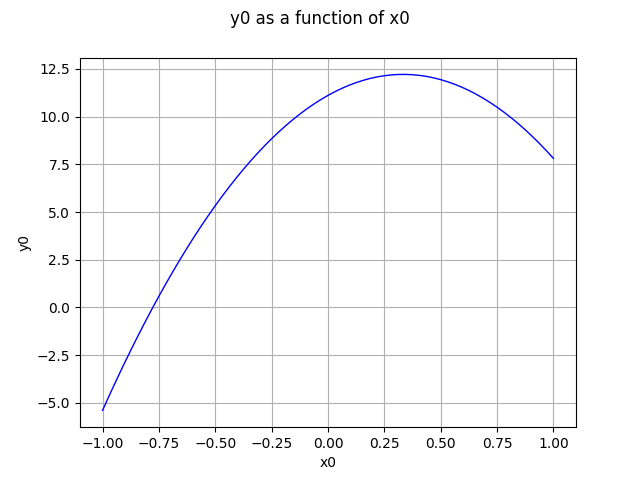

In [10]:
model.draw(-1,1)

Generate observation noise.

In [11]:
outputObservationNoiseSigma = 2. # (Pa)
observationOutputNoise = ot.Normal(0.,outputObservationNoiseSigma)

## Gaussian linear calibration

Define the covariance matrix of the output Y of the model.

In [12]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = outputObservationNoiseSigma**2
errorCovariance

class=CovarianceMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[4]

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [13]:
sigmaTheta1 = 0.1 * trueParameter[0]
sigmaTheta2 = 0.1 * trueParameter[1]
sigmaTheta3 = 0.1 * trueParameter[2]

In [14]:
parameterCovariance = ot.CovarianceMatrix(3)
parameterCovariance[0,0] = sigmaTheta1**2
parameterCovariance[1,1] = sigmaTheta2**2
parameterCovariance[2,2] = sigmaTheta3**2
parameterCovariance

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1.23432,0,0,0,0.4356,0,0,0,0.9801]

In [15]:
size = 100

In [16]:
# 1. Generate exact outputs
inputSample = inputRandomVector.getSample(size)
outputStress = g(inputSample)
# 2. Add noise
sampleNoiseH = observationOutputNoise.getSample(size)
outputObservations = outputStress + sampleNoiseH
# 3. Calibrate
inputObservations = inputSample[:,0]

In [17]:
candidate = ot.Point([12.,7.,-8])
candidate

class=Point name=Unnamed dimension=3 values=[12,7,-8]

In [18]:
algo = ot.GaussianLinearCalibration(model, inputObservations, outputObservations, \
                                    candidate, parameterCovariance, errorCovariance)
algo.run()
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [19]:
thetaStarOT = calibrationResult.getParameterMAP()
thetaStarOT

class=Point name=Unnamed dimension=3 values=[10.6907,6.68799,-9.29108]

In [20]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[10.6907,6.68799,-9.29108] sigma=class=Point name=Unnamed dimension=3 values=[0.265331,0.309039,0.540813] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.00798843,-0.66403,0.00798843,1,-0.151041,-0.66403,-0.151041,1]

In [21]:
covarianceThetaStarOT = thetaPosterior.getCovariance()
covarianceThetaStarOT

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[0.0704004,0.000655031,-0.0952845,0.000655031,0.095505,-0.0252438,-0.0952845,-0.0252438,0.292478]

## Create an empirical sample of theta

Sample theta from its gaussian prior. Keep only the ones leading to predictions close to observations.

In [22]:
priorTheta = ot.Normal(candidate,parameterCovariance)
priorTheta

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[12,7,-8] sigma=class=Point name=Unnamed dimension=3 values=[1.111,0.66,0.99] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

In [23]:
resampleSize = 160000 # Number of Theta realization to create
sampleTheta = ot.Sample(resampleSize,parameterDimension)
sampleTheta.setDescription(descr)
sampleDistance = ot.Sample(resampleSize,1)
epsilon = size # Maximum euclidian norm absolute deviation between observations and predictions
for i in range(resampleSize):
    thetaRealization = priorTheta.getRealization()
    model.setParameter(thetaRealization)
    predictions = model(inputObservations)
    residual = predictions.asPoint()-outputObservations.asPoint()
    sampleTheta[i] = thetaRealization
    sampleDistance[i,0] = residual.norm()

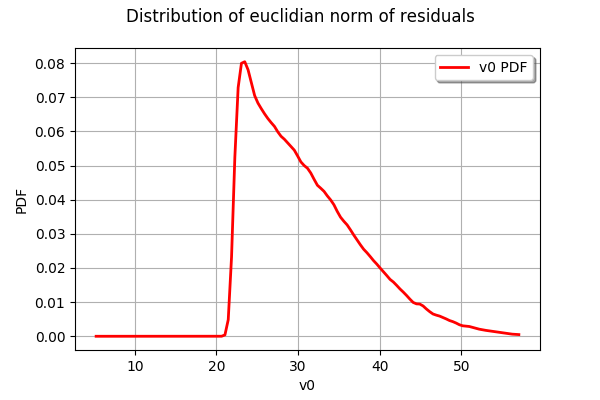

In [24]:
ksd = ot.KernelSmoothing().build(sampleDistance)
graph = ksd.drawPDF()
graph.setTitle("Distribution of euclidian norm of residuals")
graph

In [25]:
probabilityThreshold = 0.02 # The probability of having a small discrepancy
epsilon = ksd.computeQuantile(probabilityThreshold)[0]
epsilon

22.2348971863581

In [26]:
conditionalSampleIndex = 0 # Number of Theta achieving the criteria
for i in range(resampleSize):
    if (sampleDistance[i,0]<epsilon):
        conditionalSampleIndex += 1
conditionalSampleSize = conditionalSampleIndex
conditionalSampleSize

2396

In [27]:
conditionalSampleIndex = 0 # Number of Theta achieving the criteria
conditionalSample = ot.Sample(conditionalSampleSize,parameterDimension)
for i in range(resampleSize):
    if (sampleDistance[i,0]<epsilon):
        conditionalSample[conditionalSampleIndex] = sampleTheta[i]
        conditionalSampleIndex += 1

## Draw distributions

In [28]:
import pylab as pl
import openturns.viewer as otv

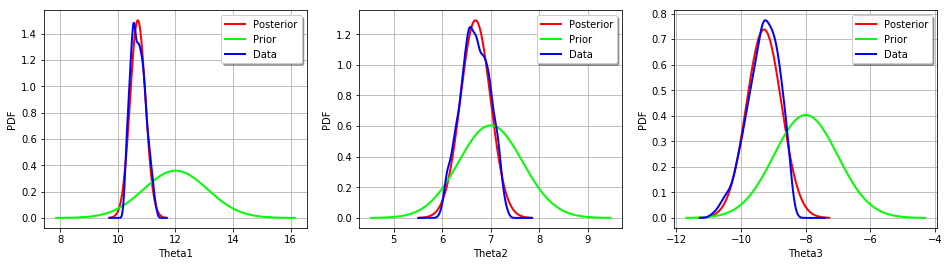

In [29]:
fig = pl.figure(figsize=(16, 4))
for i in range(parameterDimension):
    # From posterior
    thetai = thetaPosterior.getMarginal(i)
    graph = thetai.drawPDF()
    graph.setXTitle(descr[i])
    # From prior
    thetaiPriorGraph = priorTheta.getMarginal(i).drawPDF()
    thetaiPriorGraph.setColors(["green"])
    graph.add(thetaiPriorGraph)
    # From data
    sampleMargin = conditionalSample.getMarginal(i)
    ksdist = ot.KernelSmoothing().build(sampleMargin).drawPDF()
    ksdist.setColors(["blue"])
    graph.add(ksdist)
    graph.setLegends(["Posterior","Prior","Data"])
    ax = fig.add_subplot(1, parameterDimension, i+1)
    _ = otv.View(graph, figure=fig, axes=[ax])

On observe que la loi à posteriori possède la bonne moyenne et la bonne dispersion.